# Fake vs. Real News
December 28, 2020

Project goal: Implement a text mining algorithm to accurately classify data based on whether it is fake news or real news. I begin with an EDA and compare two methods in this modeling process: k-means and SVM (support vector machine). Given the incredible accuracy of the SVM, I recommend using an SVM to classify this text data. 

## Read in data & import libraries

In [37]:
import nltk, string
import re
import numpy as np
import pandas as pd
import gensim
from collections import Counter #for stopword function
from sklearn.feature_extraction.text import CountVectorizer #for stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt #for elbow method & visualization
from sklearn.datasets.samples_generator import make_blobs #for elbow method
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
########################################## OPTIONAL ##########################################
pd.set_option('display.max_colwidth', None) #this should allow us to see an entire cell (MAKES OUTPUT QUITE LONG)

In [46]:
fake = pd.read_csv("/Users/ellie/Documents/NC State/Side Project/Fake.csv") #reading in the fake news data
true = pd.read_csv("/Users/ellie/Documents/NC State/Side Project/True.csv") #reading in the real news data

## Merging the datasets 

In [47]:
#Creating identifier column for whether the observation is from fake or true news
fake["source"] = 1
true["source"] = 0
dataframes = [fake, true]
merged = pd.concat(dataframes) #merging the dataframes together
merged.tail() #Looking at the last 5 rows of the merged dataset

,title,text,subject,date,source
21412,'Fully committed' NATO backs new U.S. approach on Afghanistan,"BRUSSELS (Reuters) - NATO allies on Tuesday welcomed President Donald Trump s decision to commit more forces to Afghanistan, as part of a new U.S. strategy he said would require more troops and funding from America s partners. Having run for the White House last year on a pledge to withdraw swiftly from Afghanistan, Trump reversed course on Monday and promised a stepped-up military campaign against Taliban insurgents, saying: Our troops will fight to win . U.S. officials said he had signed off on plans to send about 4,000 more U.S. troops to add to the roughly 8,400 now deployed in Afghanistan. But his speech did not define benchmarks for successfully ending the war that began with the U.S.-led invasion of Afghanistan in 2001, and which he acknowledged had required an extraordinary sacrifice of blood and treasure . We will ask our NATO allies and global partners to support our new strategy, with additional troops and funding increases in line with our own. We are confident they will, Trump said. That comment signaled he would further increase pressure on U.S. partners who have already been jolted by his repeated demands to step up their contributions to NATO and his description of the alliance as obsolete - even though, since taking office, he has said this is no longer the case. NATO Secretary General Jens Stoltenberg said in a statement: NATO remains fully committed to Afghanistan and I am looking forward to discussing the way ahead with (Defense) Secretary (James) Mattis and our Allies and international partners. NATO has 12,000 troops in Afghanistan, and 15 countries have pledged more, Stoltenberg said. Britain, a leading NATO member, called the U.S. commitment very welcome . In my call with Secretary Mattis yesterday we agreed that despite the challenges, we have to stay the course in Afghanistan to help build up its fragile democracy and reduce the terrorist threat to the West, Defence Secretary Michael Fallon said. Germany, which has borne the brunt of Trump s criticism over the scale of its defense spending, also welcomed the new U.S. plan. Our continued commitment is necessary on the path to stabilizing the country, a government spokeswoman said. In June, European allies had already pledged more troops but had not given details on numbers, waiting for the Trump administration to outline its strategy for the region.Nearly 16 years after the U.S.-led invasion - a response to the Sept. 11 attacks which were planned by al Qaeda leader Osama bin Laden from Afghanistan - the country is still struggling with weak central government and a Taliban insurgency. Trump said he shared the frustration of the American people who were weary of war without victory , but a hasty withdrawal would create a vacuum for groups like Islamic State and al Qaeda to fill.",worldnews,"August 22, 2017",0
21413,LexisNexis withdrew two products from Chinese market,"LONDON (Reuters) - LexisNexis, a provider of legal, regulatory and business information, said on Tuesday it had withdrawn two products from the Chinese market in March this year after it was asked to remove some content. The issue of academic freedom in China hit the headlines this week after the leading British academic publisher, Cambridge University Press, said it had complied with a request to block online access to some scholarly articles in China. It later reversed its position. Earlier this year LexisNexis Business Insight Solutions in China was asked to remove some content from its database, LexisNexis said in a statement. In March 2017, the company withdrew two products (Nexis and LexisNexis Academic) from the Chinese market. LexisNexis is owned by information group Relx.",worldnews,"August 22, 2017",0
21414,Minsk cultural hub becomes haven from authorities,"MINSK (Reuters) - In the shadow of disused Soviet-era factories in Minsk, a street lined with eclectic bars, art galleries an

In [48]:
merged.text[np.random.randint(1,23000)] #taking a look at one cell of text

9664                                                                                                                                                                                          The left is going ballistic over supposed words said by President Trump to a grieving military widow.  President Trump made a call to Myeshia Wilson that has been turned into a political football by the left to make Trump out to be  crazy . Wilson s husband was killed in Niger while serving in our military.The media also wasted no time covering this story that does it s best to try and make Trump look as bad as possible Just another day in the life of the lefty media.Far left Congresswoman  Frederica Wilson jumped right in to trash Trump after the call. She s following the left s narrative by claiming Trump is a  sick man .  It s pretty funny that Wilson calls Trump crazy while wearing a glittery cowgirl hat 24/7.According to NBC: He said,  But you know he must ve known what he signed up for,  the D

In [49]:
merged.isna().any().sum() #checking for any null values

0

In [50]:
#Looking at the unique subject values & their respective countts
print(merged['subject'].value_counts())
print("*****************************")
print(merged['source'].value_counts()) #Looking at how many fake vs. real news observations we have
print("*****************************")

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64
*****************************
1    23481
0    21417
Name: source, dtype: int64
*****************************


In [51]:
print(merged.groupby(['subject', 'source']).size()) #interesting - only politicsNews & worldnews published real news

subject          source
Government News  1          1570
Middle-east      1           778
News             1          9050
US_News          1           783
left-news        1          4459
politics         1          6841
politicsNews     0         11272
worldnews        0         10145
dtype: int64


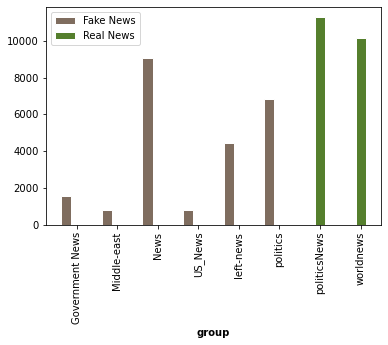

In [52]:
#Visualizing subject by source
from matplotlib import *

#setting width of the bars
barWidth = 0.25

#setting the height of the bars
bars1 = [1570, 778, 9050, 783, 4459, 6841, 0, 0] #Fake news sources
bars2 = [0, 0, 0, 0, 0, 0, 11272, 10145] #Real news sources

#setting the positions of the bars on the x-axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

#making the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Fake News')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Real News')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Government News', 'Middle-east', 'News', 'US_News', 'left-news', 'politics', 'politicsNews', 'worldnews'], rotation = 'vertical')
 
# Create legend & Show graphic
plt.legend()
plt.show()


## Splitting into Training, Test, and Validation

In [53]:
#setting the seed allows for reproducible results
np.random.seed(100)
#split data into train, test, & validation
train, validate, test = np.split(merged.sample(frac = 1), [int(0.7*len(merged)), int(0.9*len(merged))])

## Remove special characters & make text uniform

In [54]:
stop_words = nltk.corpus.stopwords.words('english') #stop words do not provide any meaning to the document (e.g. "it")
train["text"] = train["text"].str.lower() #making words lower case

In [55]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(list(train['text']))

In [56]:
stop_words = stop_words + ['quite',
  'features',
  'plenty',
  'it',
  'either',
  'said',
  'thing',   
  'Thing',
  'things',
  'Things',                         
  'one',                         
  'hitting',
  'hold',
  'least', 
  'shows',   
  'offers', 
  'well', 
  'next',   
  'like', 
  'theres', 
  'little', 
  'also', 
  'made',  
  'big', 
  'one', 
  'slightly',  
  'finishes', 
  'hints',
  'hint', 
  'note', 
  'nice', 
  'give',   
  'almost',  
  'tight', 
  'potential', 
  'weight', 
  'needs', 
  'pair', 
  'new', 
  'young', 
  'showing', 
  'packed', 
  'along', 
  'time', 
  'layers', 
  'simple', 
  'opens', 
  'yet', 
  'feel',
]

cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus) #K-means requires a matrix as input, so we create cv_matrix here

## Clustering Using K-Means 

In [ ]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

In [58]:
#Appending column with cluster label to dataframe
train['kmeans_cluster'] = km.labels_
train.head()

title  \
11383  IRS GIVES “After School Satan Club” Tax-Exempt Status in 10 Days…Tea Party Groups Still Waiting   
17483                          Talks seek to secure Islamic State withdrawal from Raqqa-local official   
8214                                      Supreme Court rejects Michigan straight-ticket voting appeal   
4320                                  U.S. says strike hits 20 percent of Syria's operational aircraft   
7559         Republican EXPLODES After Obama Foils Evil Scheme To Sell Apache Holy Land To Mining Firm   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [59]:
train1 = pd.DataFrame(train)

#Identifying accuracy of clusters
train1["accuracy"] = np.where(train1["source"] == train1["kmeans_cluster"], True, False)
train1.head()

title  \
11383  IRS GIVES “After School Satan Club” Tax-Exempt Status in 10 Days…Tea Party Groups Still Waiting   
17483                          Talks seek to secure Islamic State withdrawal from Raqqa-local official   
8214                                      Supreme Court rejects Michigan straight-ticket voting appeal   
4320                                  U.S. says strike hits 20 percent of Syria's operational aircraft   
7559         Republican EXPLODES After Obama Foils Evil Scheme To Sell Apache Holy Land To Mining Firm   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [60]:
train1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster
,count,count,count,count,count,count
accuracy,,,,,,
False,15210,15210,15210,15210,15210,15210
True,16218,16218,16218,16218,16218,16218


In [13]:
'''
Accuracy: 

Trues: 14412
Falses: 17016

14412/(31428) = 45% correct; Increasing n_int from 5 to 10 increases accuracy by 25%

'''

'\nAccuracy: \n\nTrues: 14412\nFalses: 17016\n\n14412/(31428) = 45% correct; Increasing n_int from 5 to 10 increases accuracy by 25%\n\n'

## TF - IDF 

In [14]:
'''Dr. Healey: Intuitively, TF-IDF implies the following: In any document Dj, if a term occurs frequently, 
it's an important term for characterizing Dj. Moreover, if it does not occur in many other documents, 
it's an important term for distinguishing Dj from other documents. If two documents share terms with 
high term frequency and low document frequency, they are assumed to be similar.'''

#We can't use the elbow method on text data, so will do TF - IDF and then use elbow method

"Intuitively, TF-IDF implies the following. In any document Dj, if a term it occurs frequently, \nit's an important term for characterizing Dj. Moreover, if it does not occur in many other documents, \nit's an important term for distinguishing Dj from other documents. If two documents share terms with \nhigh term frequency and low document frequency, they are assumed to be similar."

In [15]:
train1.head()

,title,text,subject,date,source,kmeans_cluster,accuracy
11383,IRS GIVES “After School Satan Club” Tax-Exempt...,after school satan club allowed by school dist...,politics,"Mar 17, 2017",1,0,False
17483,Talks seek to secure Islamic State withdrawal ...,"ain issa, syria (reuters) - remaining islamic ...",worldnews,"October 14, 2017",0,0,True
8214,Supreme Court rejects Michigan straight-ticket...,washington (reuters) - the u.s. supreme court ...,politicsNews,"September 9, 2016",0,0,True
4320,U.S. says strike hits 20 percent of Syria's op...,washington (reuters) - the u.s. cruise missile...,politicsNews,"April 10, 2017",0,0,True
7559,Republican EXPLODES After Obama Foils Evil Sc...,it s like president obama can t go a day witho...,News,"March 11, 2016",1,0,False


In [16]:
train1.text[np.random.randint(1,23000)]

7932    (reuters) - oklahoma’s highest court on tuesda...
7932    it s fairly well-known that ted cruz has few f...
Name: text, dtype: object

In [61]:
train1["text"].str.split() # has to be str.split, not .split
train_text = train1['text'].tolist()
train_text = [d.split() for d in train_text]

In [62]:
#  Convert term vectors into gensim dictionary

dict = gensim.corpora.Dictionary( train_text )

corp = [ ]
for i in range( 0, len( train_text ) ):
    corp.append( dict.doc2bow( train_text[ i ] ) )

In [63]:
#  Create TF - IDF vectors based on term vectors bag-of-word corpora

tfidf_model = gensim.models.TfidfModel( corp )

tfidf = [ ]
for i in range( 0, len( corp ) ):
    tfidf.append( tfidf_model[ corp[ i ] ] )

#  Create pairwise document similarity index

n = len( dict )
index = gensim.similarities.SparseMatrixSimilarity( tfidf_model[ corp ], num_features = n )

In [64]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import os, sys, email,re
%matplotlib inline
plt.style.use('fivethirtyeight')

In [65]:
data = train1['text']


tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',
                             max_features = 100)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

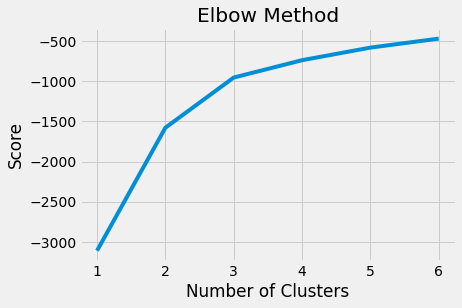

In [66]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

## Evaluating K-Means Now 

In [67]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

In [68]:
#Appending column with cluster label to dataframe
train1['kmeans_cluster_testing'] = km.labels_
train1.head()

title  \
11383  IRS GIVES “After School Satan Club” Tax-Exempt Status in 10 Days…Tea Party Groups Still Waiting   
17483                          Talks seek to secure Islamic State withdrawal from Raqqa-local official   
8214                                      Supreme Court rejects Michigan straight-ticket voting appeal   
4320                                  U.S. says strike hits 20 percent of Syria's operational aircraft   
7559         Republican EXPLODES After Obama Foils Evil Scheme To Sell Apache Holy Land To Mining Firm   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [69]:
#Identifying accuracy of clusters
train1["accuracy"] = np.where(train1["source"] == train1["kmeans_cluster_testing"], True, False)
train1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster,kmeans_cluster_testing
,count,count,count,count,count,count,count
accuracy,,,,,,,
False,15210,15210,15210,15210,15210,15210,15210
True,16218,16218,16218,16218,16218,16218,16218


In [ ]:
'''
Accuracy: 

Looks like 2 is the optimal number of clusters, as it provides highest accuracy
'''

## Evaluating Performance on Validation Data 

In [70]:
#Normalizing the data first
validate["text"] = validate["text"].str.lower()
normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(list(validate['text']))

In [71]:
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)

In [72]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

In [73]:
#Appending column with cluster label to dataframe
validate['kmeans_cluster'] = km.labels_
validate.head()

title  \
767                                  New York Mayor de Blasio wins re-election in widely expected result   
19737                                                    U.S. lawmaker wants North Korea out of the U.N.   
16120               CUBANS BRUTALLY ATTACK Brave Man Waving US Flag In Front Of Communist Parade [Video]   
15604  MISS ME YET? CNN Poll Shows America Had A Different Idea About That Whole ‘Hope and Change’ Thing   
5020     WATCH: A Nazi Apologist Has Created A Group For Young Trump Fans, And It’s Downright Terrifying   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [74]:
validate1 = pd.DataFrame(validate)

#Identifying accuracy of clusters
validate1["accuracy"] = np.where(validate1["source"] == validate1["kmeans_cluster"], True, False)
validate1.head()

title  \
767                                  New York Mayor de Blasio wins re-election in widely expected result   
19737                                                    U.S. lawmaker wants North Korea out of the U.N.   
16120               CUBANS BRUTALLY ATTACK Brave Man Waving US Flag In Front Of Communist Parade [Video]   
15604  MISS ME YET? CNN Poll Shows America Had A Different Idea About That Whole ‘Hope and Change’ Thing   
5020     WATCH: A Nazi Apologist Has Created A Group For Young Trump Fans, And It’s Downright Terrifying   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [75]:
validate1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster
,count,count,count,count,count,count
accuracy,,,,,,
False,4288,4288,4288,4288,4288,4288
True,4692,4692,4692,4692,4692,4692


In [ ]:
'''
Accuracy on validation data: 46%
'''

## Evaluating Performance on Test Data 

In [76]:
#Normalizing the data first
test["text"] = test["text"].str.lower()
normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(list(test['text']))

In [77]:
cv = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)

In [78]:
NUM_CLUSTERS = 2
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=25, n_init=10, random_state=42).fit(cv_matrix)

In [79]:
#Appending column with cluster label to dataframe
test['kmeans_cluster'] = km.labels_
test.head()

title  \
6833                                                                     Temporary U.S. government funding bill hits snag in Senate   
3977                        JUST IN: Republicans In Florida Are Giving One Presidential Candidate A Pretty Big Lead Already (VIDEO)   
15291                                                                    Tillerson says no decision yet on Trump-Putin formal talks   
21929              CLOAKED IN CONSPIRACY: Overview of JFK Files Reopens Door to Coup d’état Claims & Cold War Era False Flag Terror   
21559  OBAMA’S ARROGANCE: WATCH As He Admonishes Reporter For Asking If He Was “Content” With 4 Americans Held In Iran Jail [VIDEO]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [81]:
test1 = pd.DataFrame(test)

#Identifying accuracy of clusters
test1["accuracy"] = np.where(test1["source"] == test1["kmeans_cluster"], True, False)
test1.head()

title  \
6833                                                                     Temporary U.S. government funding bill hits snag in Senate   
3977                        JUST IN: Republicans In Florida Are Giving One Presidential Candidate A Pretty Big Lead Already (VIDEO)   
15291                                                                    Tillerson says no decision yet on Trump-Putin formal talks   
21929              CLOAKED IN CONSPIRACY: Overview of JFK Files Reopens Door to Coup d’état Claims & Cold War Era False Flag Terror   
21559  OBAMA’S ARROGANCE: WATCH As He Admonishes Reporter For Asking If He Was “Content” With 4 Americans Held In Iran Jail [VIDEO]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [83]:
test1.groupby(['accuracy']).agg(['count'])

,title,text,subject,date,source,kmeans_cluster
,count,count,count,count,count,count
accuracy,,,,,,
False,2299,2299,2299,2299,2299,2299
True,2191,2191,2191,2191,2191,2191


In [ ]:
'''
Accuracy on test data: 47%
'''

## Just for fun: Word Cloud for each Cluster & for Real and Fake News

In [84]:
#To get wordcloud to import properly, had to do the following:
import sys
print(sys.executable)

'''
Then in the terminal, copy output from the print command above (line 3) and run this: 
path/to/python -m pip install some_package
'''

/Users/ellie/Documents/anacondanavigator/anaconda3/bin/python


'\nThen in the terminal, copy output from the print command and run this: \npath/to/python -m pip install some_package\n'

In [85]:
from wordcloud import WordCloud, STOPWORDS 

comment_words = '' 
stopwords = set(STOPWORDS) 

In [86]:
cluster1 = train1.loc[(train1['kmeans_cluster'] == 1)]
cluster2 = train1.loc[(train1['kmeans_cluster'] == 0)]

fake_news = train1.loc[(train1['source'] == 1)]
real_news = train1.loc[(train1['source'] == 0)]

In [87]:
for val in cluster1.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

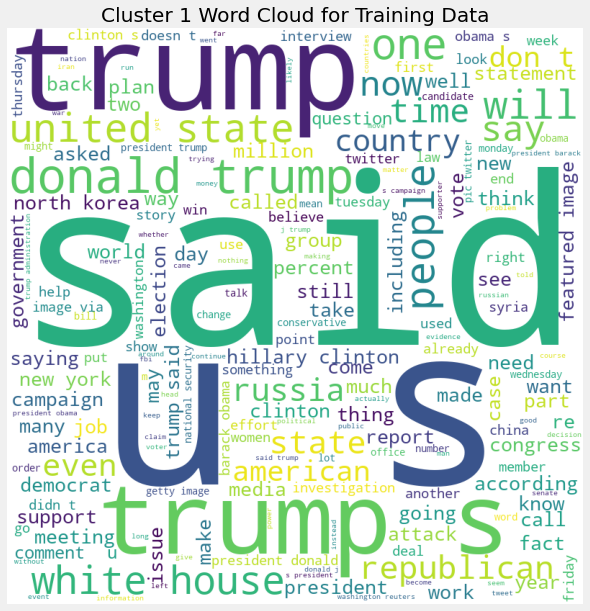

In [88]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Cluster 1 Word Cloud for Training Data")
  
plt.show() 

In [89]:
for val in cluster2.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

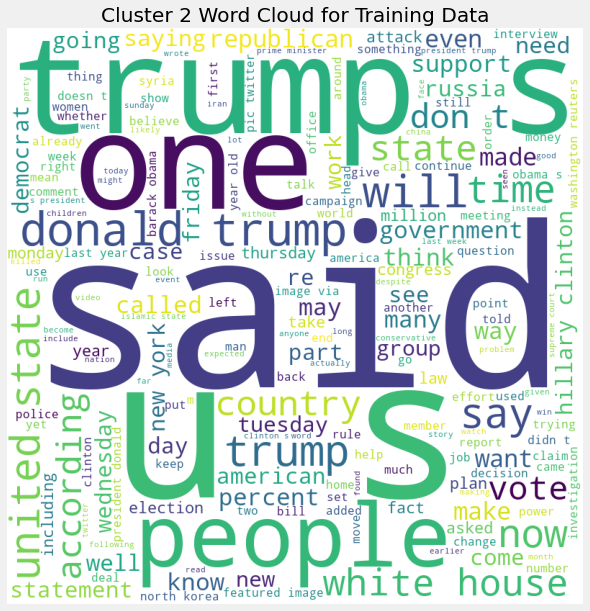

In [90]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Cluster 2 Word Cloud for Training Data")
  
plt.show() 

In [33]:
for val in fake_news.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

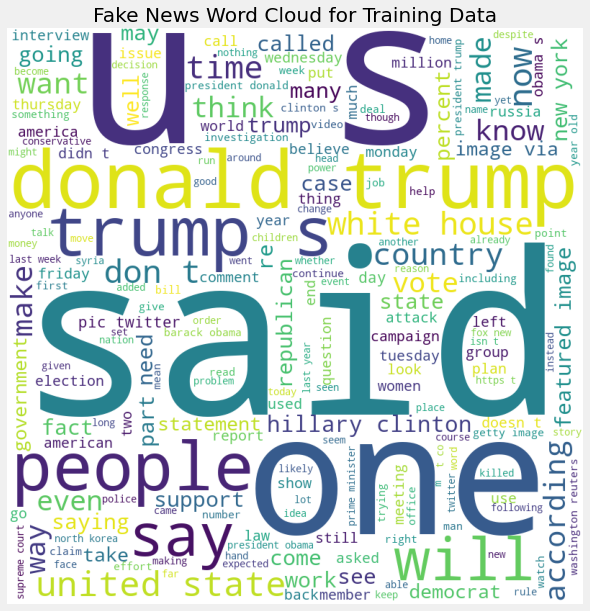

In [34]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Fake News Word Cloud for Training Data")
  
plt.show() 

In [35]:
for val in real_news.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

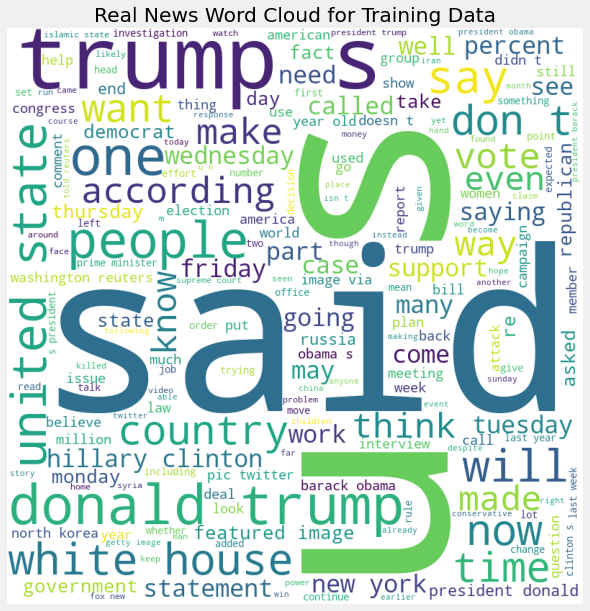

In [36]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Real News Word Cloud for Training Data")
  
plt.show() 

## Now comparing to SVC from Kaggle User

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [92]:
X=merged["text"] #feature / independent variable
y=merged["source"] # target / dependent variable

#Splitting into training & test data to evaluate accuracy & generalizability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [93]:
#Fitting the SVC using TF-IDF
clf_text=Pipeline([("tfidf",TfidfVectorizer()),("clf",LinearSVC())])
clf_text.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [94]:
predictions=clf_text.predict(X_test) #Predicting on the test dataset to evaluate accuracy & generalizability

In [95]:
#Much more accurate than k-means
print(metrics.accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test,predictions))

0.994060876020787
0.9943408360128618
